<a href="https://colab.research.google.com/github/patrycjapiechowicz/ML-Micro-Projects/blob/main/Multiclass_Classification_Problem_with_Telstra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Telstra](https://bit.ly/3dq0GvD)


### Celem jest predykcja awarii sieci (trzy możliwe stany).

In [3]:
!pip install scikit-plot

In [4]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

import scikitplot as skplt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train = pd.read_csv('/content/telstra.train.csv.zip', compression='zip')
test = pd.read_csv('/content/telstra.test.csv.zip', compression='zip')

event_type = pd.read_csv('/content/telstra.event_type.csv.zip', compression='zip')
resource_type = pd.read_csv('/content/telstra.resource_type.csv.zip', compression='zip')
severity_type = pd.read_csv('/content/telstra.severity_type.csv.zip', compression='zip')
log_feature = pd.read_csv('/content/telstra.log_feature.csv.zip', compression='zip')

#there is no need to extract zip before!:)

In [25]:

event_type.head(2)

,id,event_type
0,6597,event_type 11
1,8011,event_type 15


In [26]:
resource_type.head(2)

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8


In [27]:
severity_type.head(2)

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2


In [28]:
log_feature.head(2)

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7


## EDA

In [7]:
print(train.shape, test.shape)
train.sample(10)


(7381, 3) (11171, 2)


,id,location,fault_severity
6306,1424,location 414,0
4534,5375,location 7,1
1995,10911,location 211,0
4156,6516,location 469,0
6327,2434,location 810,2
1696,8341,location 332,0
4313,28,location 889,0
5684,12953,location 704,0
4901,6467,location 1035,1
6645,3832,location 519,0


In [8]:
print("Train, unq ID:", train.id.nunique())
print("Train, unq location:", train.location.nunique())
print("")
print("Test, unq ID:", test.id.nunique())
print("Test, unq location:", test.location.nunique())
print("")
print("All unique locations: ",  len(set(train.location) | set(test.location)))
print("New locations (in test): ", len(set(test.location) - set(train.location)))

Train, unq ID: 7381
Train, unq location: 929

Test, unq ID: 11171
Test, unq location: 1039

All unique locations:  1126
New locations (in test):  197


In [9]:
if np.int != train.location.dtype:
    train['location'] = train.location.map(lambda x: x.split(' ')[1]).astype(np.int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              7381 non-null   int64
 1   location        7381 non-null   int64
 2   fault_severity  7381 non-null   int64
dtypes: int64(3)
memory usage: 173.1 KB


<ipython-input-9-85c1811785c5>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.int != train.location.dtype:
<ipython-input-9-85c1811785c5>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

## Target variable - `fault_severity`

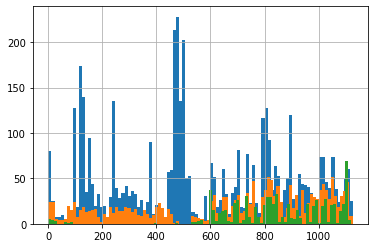

In [10]:
train[ train.fault_severity == 0  ].location.hist(bins=100)
train[ train.fault_severity == 1  ].location.hist(bins=100)
train[ train.fault_severity == 2  ].location.hist(bins=100);

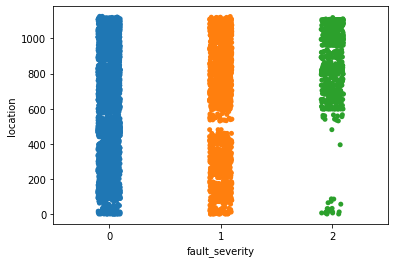

In [11]:
sns.stripplot(x="fault_severity", y="location", data=train, jitter=True);

## Event type-rodzaje zdarzeń.

In [12]:
print(event_type.shape)
print("unique ID: ", event_type.id.nunique())
print("unique event_type: ", event_type.event_type.nunique())
event_type.sample(5)

(31170, 2)
unique ID:  18552
unique event_type:  53


,id,event_type
9162,16172,event_type 11
6189,5275,event_type 35
3107,2811,event_type 15
27723,1994,event_type 44
15664,1301,event_type 35


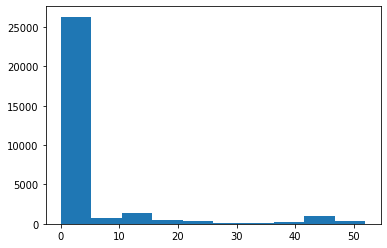

In [13]:
plt.hist( event_type.event_type.factorize()[0] );

In [14]:
event_type.event_type.value_counts(normalize=True).head(15)

event_type 11    0.253064
event_type 35    0.212223
event_type 34    0.190151
event_type 15    0.141001
event_type 20    0.046776
event_type 54    0.021944
event_type 13    0.018672
event_type 42    0.015335
event_type 44    0.014950
event_type 23    0.013763
event_type 14    0.010587
event_type 43    0.009817
event_type 22    0.007154
event_type 50    0.004941
event_type 10    0.004652
Name: event_type, dtype: float64

**event_type 11** jest najbardziej popularnym zdarzeniem (25%), następnie **event_type 35** - 21%, **event_type 34** - 19%, **event_type 15** - 14%. Pierwsze cztery zdarzenia stanowią ok. 80%.

## Resource type

In [15]:
print(resource_type.shape)
print("unique ID: ", resource_type.id.nunique())
print("unique resource_type: ", resource_type.resource_type.nunique())
resource_type.sample(5)

(21076, 2)
unique ID:  18552
unique resource_type:  10


,id,resource_type
5931,12069,resource_type 2
4094,10070,resource_type 2
19020,3545,resource_type 6
6377,1577,resource_type 2
10068,8564,resource_type 2


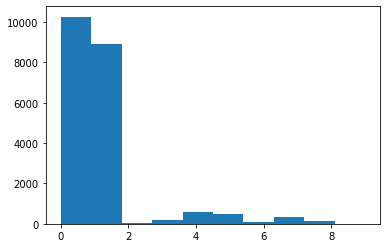

In [16]:
plt.hist( resource_type.resource_type.factorize()[0] );

In [17]:
resource_type.resource_type.value_counts(normalize=True)

resource_type 8     0.487189
resource_type 2     0.423135
resource_type 6     0.027614
resource_type 7     0.023629
resource_type 4     0.015658
resource_type 9     0.009015
resource_type 3     0.006880
resource_type 10    0.003464
resource_type 1     0.002752
resource_type 5     0.000664
Name: resource_type, dtype: float64

**resource_type 8** ma ok. 49%, **resource_type 2** - 42%, co pokrywa ponad 90%.

## Severity_type

In [19]:
print(severity_type.shape)
print("unique ID: ", severity_type.id.nunique())
print("unique severity_type: ", severity_type.severity_type.nunique())
severity_type.sample(5)

(18552, 2)
unique ID:  18552
unique severity_type:  5


,id,severity_type
5521,4523,severity_type 2
13939,553,severity_type 1
16247,9797,severity_type 1
12428,15674,severity_type 1
13120,14887,severity_type 1


In [18]:
severity_type.severity_type.value_counts(normalize=True)

severity_type 2    0.470947
severity_type 1    0.470461
severity_type 4    0.054657
severity_type 5    0.003504
severity_type 3    0.000431
Name: severity_type, dtype: float64

In [20]:
def cv_model(model, X, y, n_splits=3):

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=2018, shuffle=True)

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict_proba(X[test_idx])

        scores.append( log_loss(y[test_idx], y_pred) )
        
    return np.mean(scores), np.std(scores)

In [21]:
X = train[ ['location'] ].values
y = train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.8035725329559632, 0.03883194903503622)

Drzewa decyzyjne dają wynik: **0.838**. 

## Try to merge tables, first severity_type with train

In [22]:
combined_train = pd.merge(severity_type, train, on='id')

combined_train

,id,severity_type,location,fault_severity
0,8011,severity_type 2,1,0
1,2588,severity_type 1,1,0
2,4848,severity_type 1,1,0
3,6914,severity_type 1,1,0
4,5337,severity_type 1,1,0
...,...,...,...,...
7376,6288,severity_type 1,999,1
7377,13296,severity_type 1,999,1
7378,8114,severity_type 2,999,0
7379,878,severity_type 2,999,0


In [23]:
combined_train.location.value_counts().head()

821     85
1107    78
734     75
1008    71
126     71
Name: location, dtype: int64

In [29]:
#reset index
tmp_exp = combined_train[ combined_train.location == 821 ].reset_index()
tmp_exp['id'] = tmp_exp.index
print(tmp_exp.shape)
tmp_exp.head()

(85, 5)


,index,id,severity_type,location,fault_severity
0,5860,0,severity_type 1,821,0
1,5861,1,severity_type 1,821,0
2,5862,2,severity_type 1,821,0
3,5863,3,severity_type 1,821,0
4,5864,4,severity_type 1,821,0


In [24]:
def plot_by_location(location_id):
    tmp_exp = combined_train[ combined_train.location == location_id ].reset_index()
    tmp_exp['id'] = tmp_exp.index

    sns.set(rc={'figure.figsize':(15,5)})

    plt.plot( tmp_exp[ tmp_exp.fault_severity == 0 ].id, tmp_exp[ tmp_exp.fault_severity == 0 ].fault_severity, 'o' )
    plt.plot( tmp_exp[ tmp_exp.fault_severity == 1 ].id, tmp_exp[ tmp_exp.fault_severity == 1 ].fault_severity, 'o' )
    plt.plot( tmp_exp[ tmp_exp.fault_severity == 2 ].id, tmp_exp[ tmp_exp.fault_severity == 2 ].fault_severity, 'o' )
    plt.title("Location {0}".format(location_id), fontsize=20)
    plt.xlabel("Num", fontsize=16)
    plt.ylabel("Fault severity", fontsize=16)
    plt.show()

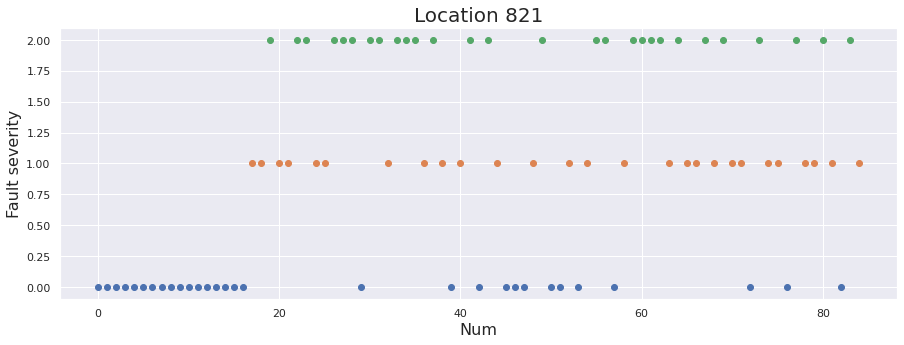

In [30]:
plot_by_location(821)

In [ ]:
plot_by_location(1107)

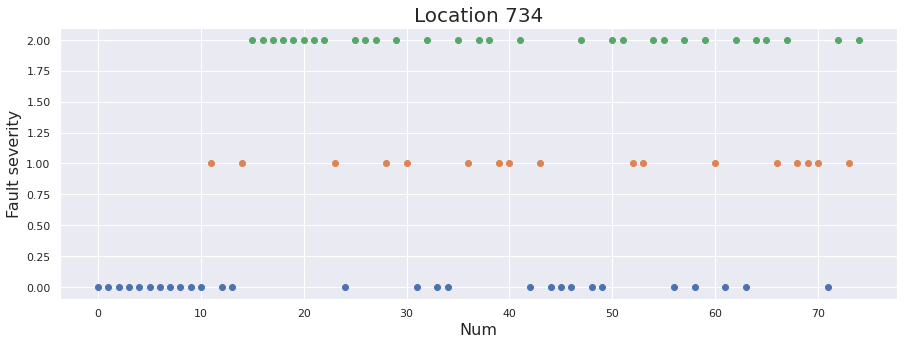

In [31]:
plot_by_location(734)

In [32]:
combined_train['time'] = combined_train.groupby('location')['severity_type'].transform(lambda x: np.arange(x.shape[0])+1)
combined_train['reverse_time'] = combined_train.groupby('location')['severity_type'].transform(lambda x: np.arange(x.shape[0])[::-1]+1)

combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time
0,8011,severity_type 2,1,0,1,24
1,2588,severity_type 1,1,0,2,23
2,4848,severity_type 1,1,0,3,22
3,6914,severity_type 1,1,0,4,21
4,5337,severity_type 1,1,0,5,20


In [33]:
X = combined_train[ ['location', 'time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.8268849840870119, 0.028977305219066718)

In [34]:
X = combined_train[ ['location', 'reverse_time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.795292325423025, 0.05361078304768331)

In [35]:
X = combined_train[ ['location', 'reverse_time', 'time'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.7563630985981975, 0.03504595647558953)

improvement from **0.838**. to **0.75**.

## Location count


In [36]:
combined_train[ ['location', 'time'] ].groupby('location').agg(len).head(5)

,time
location,
1,24
2,7
3,2
4,2
5,1


In [37]:
location_count = combined_train[ ['location', 'time'] ].groupby('location').agg(len).to_dict()['time']
combined_train['location_count'] = combined_train['location'].map(lambda x: location_count[x])

combined_train.head()

,id,severity_type,location,fault_severity,time,reverse_time,location_count
0,8011,severity_type 2,1,0,1,24,24
1,2588,severity_type 1,1,0,2,23,24
2,4848,severity_type 1,1,0,3,22,24
3,6914,severity_type 1,1,0,4,21,24
4,5337,severity_type 1,1,0,5,20,24


In [38]:
X = combined_train[ ['location', 'reverse_time', 'time', 'location_count'] ].values
y = combined_train['fault_severity'].values

cv_model(DecisionTreeClassifier(max_depth=5), X, y)

(0.7540138486008233, 0.02825339391234813)

Small improvement